Car order: ['WEAD', 'PROFACC', 'WEAD', 'PROFACC', 'WEAD', 'PROFACC', 'WEAD', 'PROFACC', 'WEAD', 'PROFACC', 'WEAD', 'PROFACC']


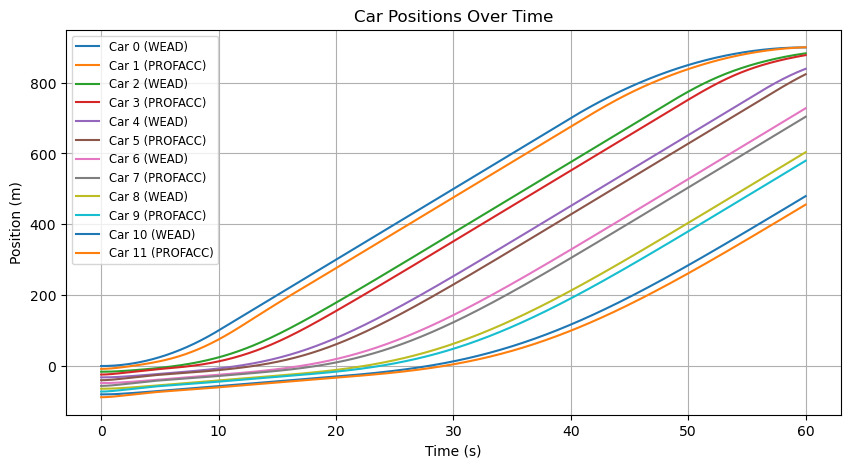

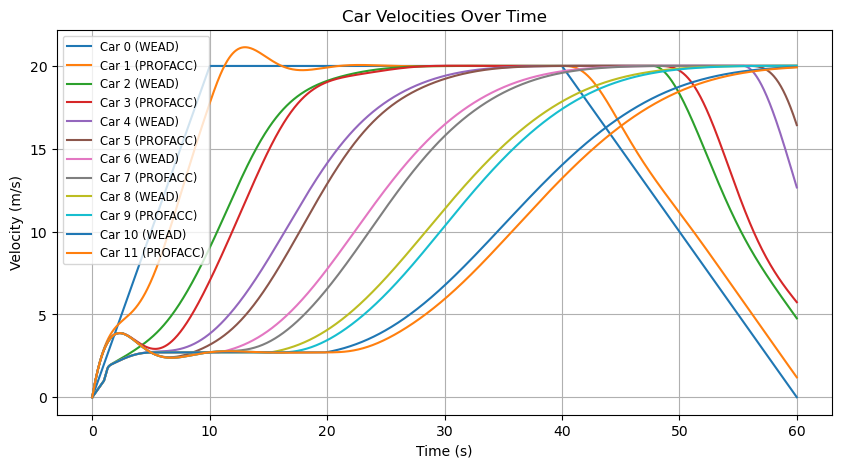

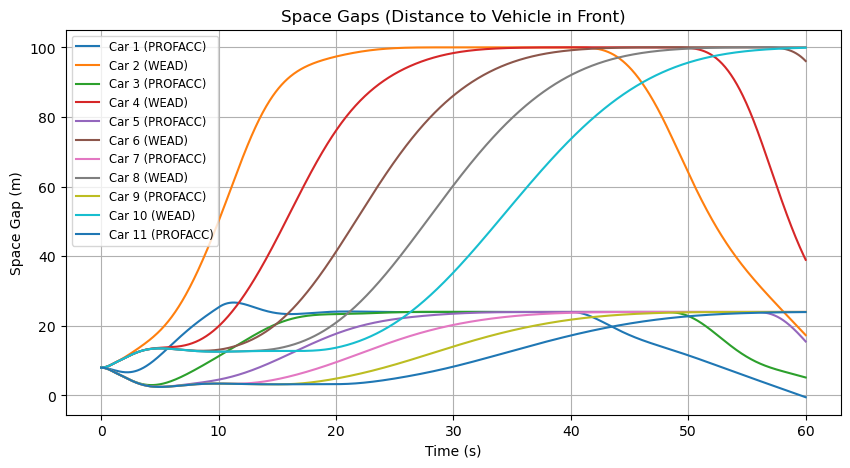

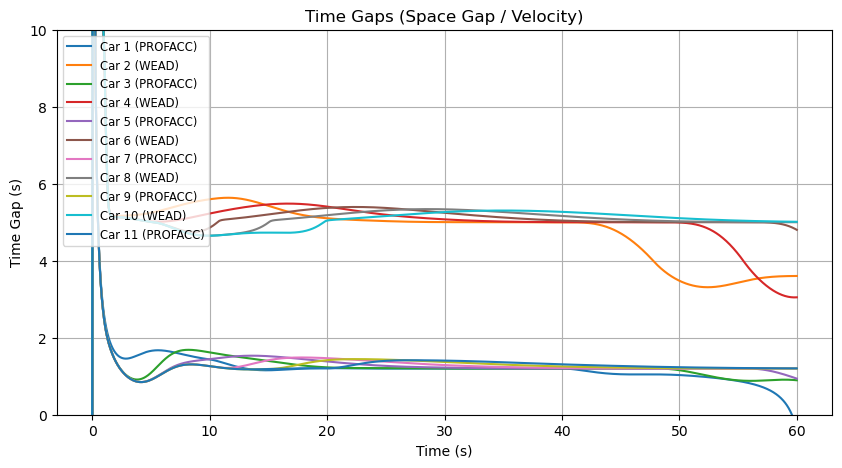

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
#  WEAD CONTROLLER
# ============================================================
def wead_controller(sn, vn):
    STOPPED_SPEED_TH = 1.0
    STOPPED_MIN_GAP = 5.0
    STOPPED_ACCEL = 1.0

    MAX_ACCEL = 2.5
    MAX_BRAKE = -2.5

    CRUISE_SPEED_LIMIT = 36.0

    if vn <= STOPPED_SPEED_TH:
        if sn > STOPPED_MIN_GAP:
            return STOPPED_ACCEL
        else:
            return 0.0

    time_gap = sn / vn if vn > 0 else float('inf')

    if time_gap <= 3:
        return MAX_BRAKE
    elif time_gap < 4:
        return (2.5 * time_gap) - 10
    elif time_gap <= 5:
        return 0.0
    elif time_gap < 6:
        return (2.5 * time_gap) - 12.5
    elif time_gap >= 6:
        return MAX_ACCEL if vn <= CRUISE_SPEED_LIMIT else 0.0

    return 0.0


# ============================================================
#  PROFACC CONTROLLER 
# ============================================================
def profacc_controller(sn, vn, alpha=0.5, tau=1.2):
    return alpha * (sn - tau * vn)


# ============================================================
# Leader velocity profile (Applied to Car 0)
# ============================================================
def car0_velocity_profile(t):
    if t < 10:
        return 2.0 * t              # accelerate to 20 m/s
    elif t < 40:
        return 20.0                 # cruise
    else:
        return max(0, 20 - 1*(t-40))  # brake


# ============================================================
#  CAR ORDERING FUNCTION
# ============================================================
def assign_controllers(num_wead, ordering):
    total = 12
    num_prof = total - num_wead

    if ordering == "front":
        return ["WEAD"] * num_wead + ["PROFACC"] * num_prof
    elif ordering == "back":
        return ["PROFACC"] * num_prof + ["WEAD"] * num_wead
    elif ordering == "interspersed":
        controller_list = ["PROFACC"] * total
        if num_wead > 0:
            spacing = total / num_wead
            for i in range(num_wead):
                idx = int(i * spacing)
                if idx < total:
                    controller_list[idx] = "WEAD"
        return controller_list
    else:
        raise ValueError("ordering must be 'front', 'back', or 'interspersed'")


# ============================================================
#  MAIN PLATOON SIMULATION
# ============================================================
def simulate_platoon(num_wead_cars, ordering):

    # Assign controllers to all cars (including Car 0, though Car 0 uses a fixed profile)
    controllers = assign_controllers(num_wead_cars, ordering)
    print("Car order:", controllers)

    dt = 0.05
    T = 60
    N = int(T/dt)

    t = np.linspace(0, T, N)

    # State arrays for 12 cars
    x = np.zeros((12, N))      # positions
    v = np.zeros((12, N))      # velocities
    a = np.zeros((12, N))      # accelerations
    
    # Metric arrays
    space_gaps = np.zeros((12, N)) # Gap to the car in front
    time_gaps  = np.zeros((12, N)) # space_gap / velocity

    # Initial positions (cars spaced 8 m apart)
    for i in range(12):
        x[i, 0] = -8 * i
        
        # Calculate initial gaps (valid for everyone except Car 0)
        if i > 0:
            space_gaps[i, 0] = x[i-1, 0] - x[i, 0]

    # Simulate
    for k in range(1, N):

        # === Car 0 Motion (Pre-defined Profile) ===
        v[0, k] = car0_velocity_profile(t[k])
        x[0, k] = x[0, k-1] + v[0, k] * dt
        # Car 0 has no one in front, so its gaps remain 0

        # === Follower Motion (Cars 1 through 11) ===
        for car in range(1, 12):
            
            # 1. Calculate Inputs based on the car directly in front (car-1)
            sn = x[car-1, k-1] - x[car, k-1]
            vn = v[car, k-1]
            
            # 2. Store metrics
            space_gaps[car, k] = sn
            if vn > 0.1:
                time_gaps[car, k] = sn / vn
            else:
                time_gaps[car, k] = 20.0 # Cap for plotting when stopped

            # 3. Calculate Control Output
            if controllers[car] == "WEAD":
                acc = wead_controller(sn, vn)
            else:
                acc = profacc_controller(sn, vn)

            # 4. Update State
            a[car, k] = acc
            v[car, k] = max(0, v[car, k-1] + acc * dt)
            x[car, k] = x[car, k-1] + v[car, k] * dt

    return t, x, v, space_gaps, time_gaps, controllers


# ============================================================
#  RUN + PLOT
# ============================================================
if __name__ == "__main__":
    # Setup
    num_wead_cars = 6           
    ordering = "interspersed"    

    # Run Simulation
    t, x, v, s_gaps, t_gaps, controllers = simulate_platoon(num_wead_cars, ordering)

    # ---- Plot Positions ----
    plt.figure(figsize=(10, 5))
    for car in range(12):
        # Uniform labeling for all cars
        plt.plot(t, x[car], label=f"Car {car} ({controllers[car]})")
    plt.title("Car Positions Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.grid()
    plt.legend(loc='upper left', fontsize='small')
    plt.show()

    # ---- Plot Velocities ----
    plt.figure(figsize=(10, 5))
    for car in range(12):
        plt.plot(t, v[car], label=f"Car {car} ({controllers[car]})")
    plt.title("Car Velocities Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m/s)")
    plt.grid()
    plt.legend(loc='upper left', fontsize='small')
    plt.show()

    # ---- Plot Space-Gaps ----
    plt.figure(figsize=(10, 5))
    # We only plot gaps for cars that HAVE a car in front of them (1 to 11)
    for car in range(1, 12):
        plt.plot(t, s_gaps[car], label=f"Car {car} ({controllers[car]})")
    plt.title("Space Gaps (Distance to Vehicle in Front)")
    plt.xlabel("Time (s)")
    plt.ylabel("Space Gap (m)")
    plt.grid()
    plt.legend(loc='upper left', fontsize='small')
    plt.show()

    # ---- Plot Time-Gaps ----
    plt.figure(figsize=(10, 5))
    for car in range(1, 12):
        plt.plot(t, t_gaps[car], label=f"Car {car} ({controllers[car]})")
    plt.title("Time Gaps (Space Gap / Velocity)")
    plt.xlabel("Time (s)")
    plt.ylabel("Time Gap (s)")
    plt.ylim(0, 10) 
    plt.grid()
    plt.legend(loc='upper left', fontsize='small')
    plt.show()

In [8]:
# ============================================================
# RUN VERSION: 3 WEAD + 9 PRO-FACC
# ============================================================

your_num_wead = 3
your_ordering = "interspersed"  # evenly spaced, as you designed

t2, x2, v2, s2, tg2, ctrl2 = simulate_platoon(your_num_wead, your_ordering)

print("Your controller assignment:", ctrl2)


Car order: ['WEAD', 'PROFACC', 'PROFACC', 'PROFACC', 'WEAD', 'PROFACC', 'PROFACC', 'PROFACC', 'WEAD', 'PROFACC', 'PROFACC', 'PROFACC']
Your controller assignment: ['WEAD', 'PROFACC', 'PROFACC', 'PROFACC', 'WEAD', 'PROFACC', 'PROFACC', 'PROFACC', 'WEAD', 'PROFACC', 'PROFACC', 'PROFACC']


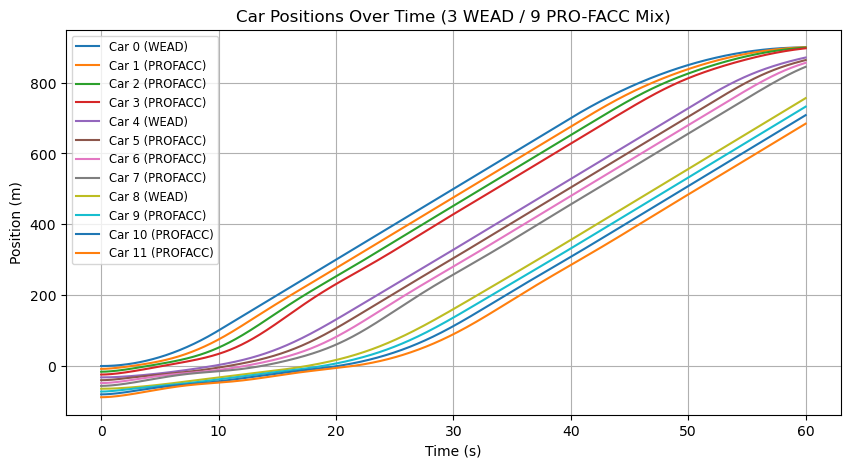

In [9]:
# ============================================================
# POSITIONS
# ============================================================

plt.figure(figsize=(10,5))
for car in range(12):
    plt.plot(t2, x2[car], label=f"Car {car} ({ctrl2[car]})")

plt.title("Car Positions Over Time (3 WEAD / 9 PRO-FACC Mix)")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.grid()
plt.legend(loc='upper left', fontsize='small')
plt.show()


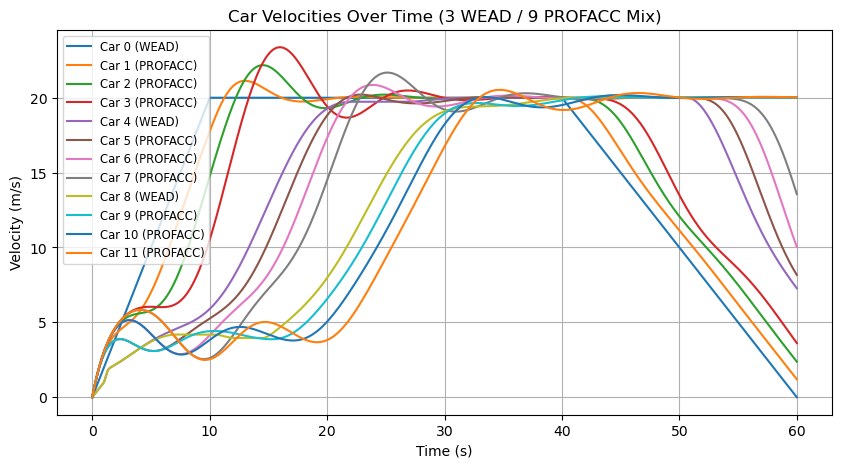

In [10]:
# ============================================================
# YOUR PLOTTING — VELOCITIES
# ============================================================

plt.figure(figsize=(10,5))
for car in range(12):
    plt.plot(t2, v2[car], label=f"Car {car} ({ctrl2[car]})")

plt.title("Car Velocities Over Time (3 WEAD / 9 PROFACC Mix)")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.grid()
plt.legend(loc='upper left', fontsize='small')
plt.show()


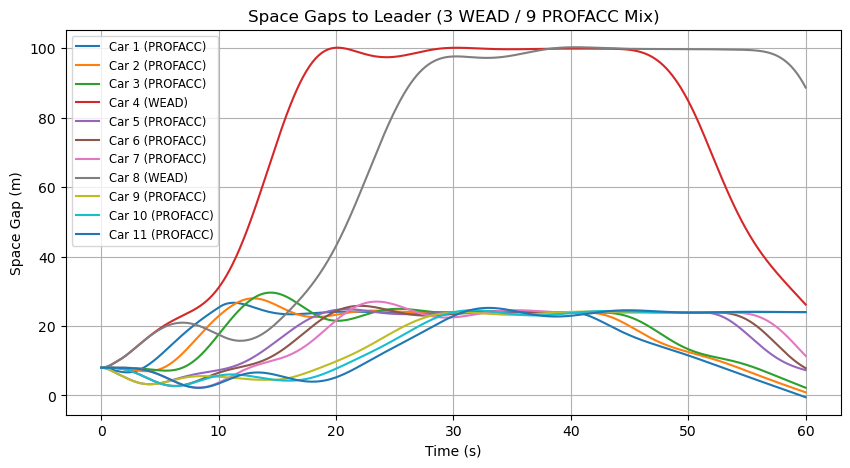

In [11]:
# ============================================================
# YOUR PLOTTING — SPACE GAPS
# ============================================================

plt.figure(figsize=(10,5))
for car in range(1, 12):  # no gap for Car 0
    plt.plot(t2, s2[car], label=f"Car {car} ({ctrl2[car]})")

plt.title("Space Gaps to Leader (3 WEAD / 9 PROFACC Mix)")
plt.xlabel("Time (s)")
plt.ylabel("Space Gap (m)")
plt.grid()
plt.legend(loc='upper left', fontsize='small')
plt.show()


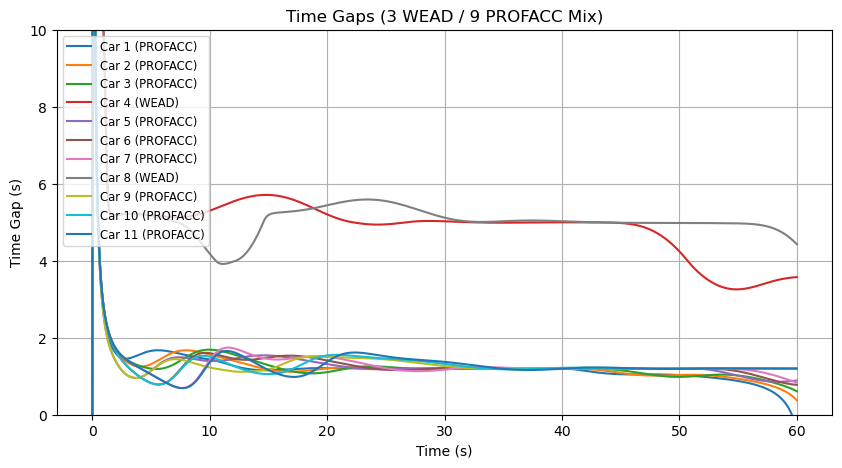

In [12]:
# ============================================================
# PLOTTING — TIME GAPS
# ============================================================

plt.figure(figsize=(10,5))
for car in range(1, 12):
    plt.plot(t2, tg2[car], label=f"Car {car} ({ctrl2[car]})")

plt.title("Time Gaps (3 WEAD / 9 PROFACC Mix)")
plt.xlabel("Time (s)")
plt.ylabel("Time Gap (s)")
plt.ylim(0, 10)
plt.grid()
plt.legend(loc='upper left', fontsize='small')
plt.show()
